In [1]:
# Import modules
# Modules for data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import cv2
from matplotlib import pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Modules for image processing
from PIL import Image

# Modules for model building
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

In [2]:
# Load datasets
imgBase_dir = 'UTKFace'

In [3]:
# Creating labels for images by looping through image in the imgBase_dir
img_paths = []
age_arr = []
gender_arr = []

for files in os.listdir(imgBase_dir):
    img_path = os.path.join(imgBase_dir, files) #Get image paths
    info = files.split('_')
    img_paths.append(img_path)
    age_arr.append(int(info[0]))
    gender_arr.append(int(info[1]))

In [4]:
# Convert labesl to dataframe for analyzing
df = pd.DataFrame()
df['img_path'], df['age'], df['gender'] = img_paths, age_arr, gender_arr
df.head()

,img_path,age,gender
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,1


In [5]:
# Create dict for gender labels
gender_dict = {0: 'male', 1: 'female'}

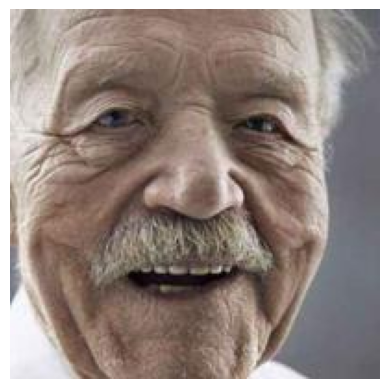

In [6]:
# Analyze datasets
img = Image.open(df['img_path'][0])
plt.axis('off')
plt.imshow(img)

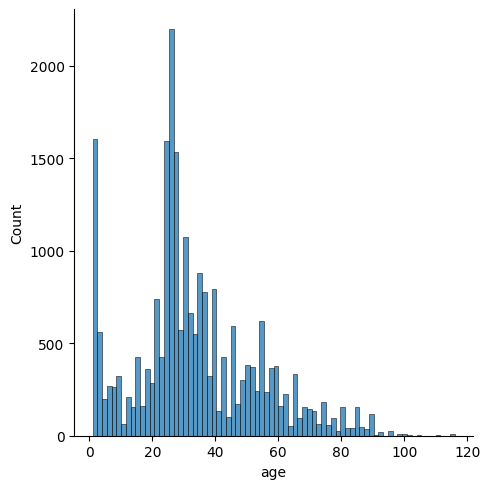

In [7]:
# Age Distribution in the Dataset
sns.displot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

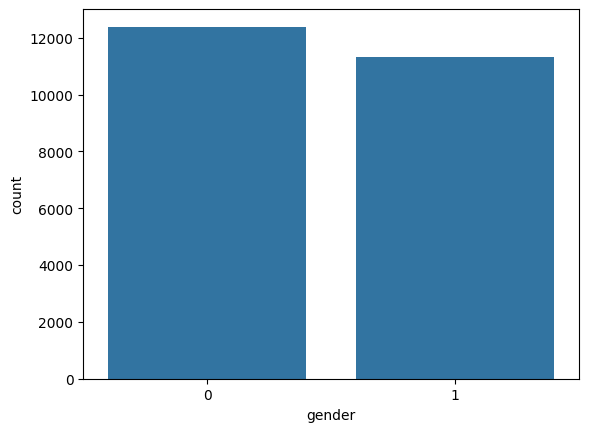

In [8]:
sns.countplot(x = df['gender'])

In [9]:
# The data has more male than female iamges --> solution is too add more images from 
# UTK Datasets

In [10]:
# Extracting Facial Feature
# Function that extract important facial_expressions
def facial_exp_extract(images):
    facial_features = []
    for imgs in images:
        img = load_img(imgs, color_mode = 'grayscale')
        img = np.array(img.resize((128, 128), Image.Resampling.LANCZOS))
        facial_features.append(img)

    # Convert facial features to np.arr for modeling
    facial_features = np.array(facial_features)
    facial_features = facial_features.reshape(len(facial_features), 128, 128, 1) #Reshape to the same img size, height = width = 128, in grayscale
    return facial_features

    

In [11]:
# Getting the facial_features from images
X = facial_exp_extract(df['img_path'])
X.shape

(23708, 128, 128, 1)

In [12]:
# Normalize images for modeling
X = X / 255

In [13]:
# Create gender axis for modeling
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [14]:
input_shape = (128, 128, 1) #Height = width = 128, using grayscale

In [15]:
# Creating model for classification
inputs = Input(input_shape)

# Create convo layers and pool_size for 5 times
conv = Conv2D(32, kernel_size = (3, 3), activation = 'relu')(inputs)
maxp = MaxPooling2D(pool_size = (2,2))(conv)

for count in range(0, 4, 1):
    conv = Conv2D(32, kernel_size = (3,3), activation = 'relu')(maxp)
    maxp = MaxPooling2D(pool_size = (2,2))(conv)

# Flatten the images after maxpooling
flatten_img = Flatten()(maxp)


In [16]:
# Connect all the layers using Dense, Dropout
def dense_by_type(activation_type, type_name, flatten):
    dense = Dense(256, activation = 'relu')(flatten)
    dropout = Dropout(0.3)(dense)
    return Dense(1, activation = activation_type, name = type_name)(dropout)

In [17]:
# Get densed output for gender and age
dense_gender = dense_by_type('sigmoid', 'gender', flatten_img)
dense_age = dense_by_type('relu', 'age', flatten_img)

In [18]:
# Model
model = Model(inputs = [inputs], outputs = [dense_gender, dense_age])
model.compile(loss = ['binary_crossentropy', 'mean_squared_error'], optimizer = 'adam', metrics = ['accuracy', 'mae'])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 126, 126, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 63, 63, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 32)        │           9,248 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 30, 30, 32)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 32)        │           9,248 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 14, 14, 32)        │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 12, 12, 32)        │           9,248 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 6, 32)          │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 4, 4, 32)          │           9,248 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 2, 2, 32)          │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 128)               │               0 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          33,024 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          33,024 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 103,874 (405.76 KB)

 Trainable params: 103,874 (405.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
trained_model = model.fit(x = X, y = [y_gender, y_age], batch_size = 32, epochs = 25, validation_split = 0.2)

Epoch 1/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - age_mae: 12.6058 - gender_accuracy: 0.5222 - loss: 273.3286 - val_age_mae: 33.3576 - val_gender_accuracy: 0.6261 - val_loss: 1262.5779
Epoch 2/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - age_mae: 9.3047 - gender_accuracy: 0.6094 - loss: 147.3380 - val_age_mae: 28.2280 - val_gender_accuracy: 0.7244 - val_loss: 949.9330
Epoch 3/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - age_mae: 7.8425 - gender_accuracy: 0.7352 - loss: 108.8764 - val_age_mae: 26.3954 - val_gender_accuracy: 0.7347 - val_loss: 841.5127
Epoch 4/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - age_mae: 7.2540 - gender_accuracy: 0.7645 - loss: 94.1038 - val_age_mae: 28.8797 - val_gender_accuracy: 0.7478 - val_loss: 1024.6411
Epoch 5/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - age_mae: 7.0100 - gender_accuracy: 0.7763 - loss: 90.9635 - val_age_mae: 27.6590 - val_gender_accuracy: 0.7419 - val_loss: 933.6179
Epoch 6/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step 

In [23]:
# Plot the results for gender
accuracy = trained_model.history['gender_accuracy']
val_accuracy = trained_model.history['val_gender_accuracy']
epochs =  range(len(accuracy))

loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

<Figure size 640x480 with 0 Axes>

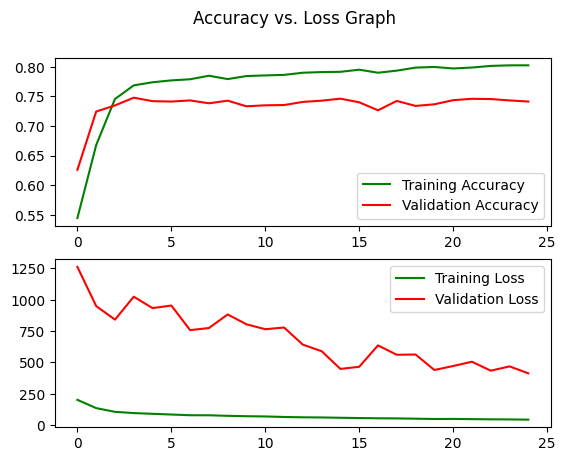

<Figure size 640x480 with 0 Axes>

In [22]:
fig, (plt1, plt2) = plt.subplots(2)

fig.suptitle('Accuracy vs. Loss Graph')

plt1.plot(epochs, accuracy, 'g', label = 'Training Accuracy')
plt1.plot(epochs, val_accuracy, 'r', label = 'Validation Accuracy')
plt1.legend()

plt2.plot(epochs, loss, 'g', label = 'Training Loss')
plt2.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt2.legend()

plt.figure()

<Figure size 640x480 with 0 Axes>

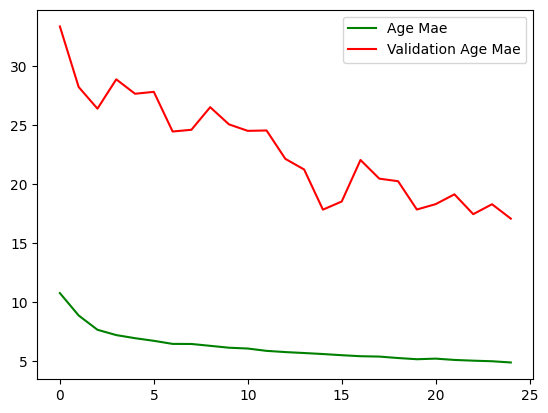

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot results for age
age_mae = trained_model.history['age_mae']
val_age_mae = trained_model.history['val_age_mae']
epochs =  range(len(accuracy))

plt.plot(epochs, age_mae, 'g', label = 'Age Mae')
plt.plot(epochs, val_age_mae, 'r', label = 'Validation Age Mae')
plt.legend()
plt.figure()

Original Gender:  male Original Age:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Pred Gender:  female Pred Age:  16


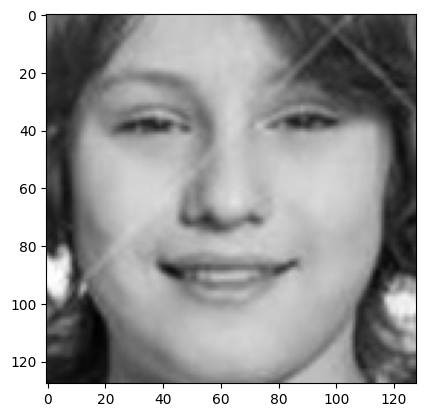

In [29]:
# Prediction with test data
img_idx = 200
print('Original Gender: ', gender_dict[y_gender[img_idx]], 'Original Age: ', y_age[img_idx])

# Predict from model
pred = model.predict(X[img_idx].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Pred Gender: ', pred_gender, 'Pred Age: ', pred_age)
plt.imshow(X[img_idx].reshape(128, 128), cmap = 'gray')
